# Introduction

### General Background

Hello! We are Maayan Astary (328191275) and Yuvak Maharshak (216371500).

In this notebook, we will showcase the Human Protein Atlas Cell Classification competition from Kaggle, and our approach to solving it.

### The Problem

The goal of this competition is to classify patterns of proteins in microscope images of cells. Each image may exhibit one or more distinct patterns of such proteins, making this a multi label classification challenge.

A good solution to this problem has the potential to significantly advance biomedical research and, as a byproduct, could have a profound impact on medical science.

The possible Labels are:

0.  Nucleoplasm
1.  Nuclear membrane
2.  Nucleoli
3.  Nucleoli fibrillar center
4.  Nuclear speckles
5.  Nuclear bodies
6.  Endoplasmic reticulum
7.  Golgi apparatus
8.  Peroxisomes
9.  Endosomes
10.  Lysosomes
11.  Intermediate filaments
12.  Actin filaments
13.  Focal adhesion sites
14.  Microtubules
15.  Microtubule ends
16.  Cytokinetic bridge
17.  Mitotic spindle
18.  Microtubule organizing center
19.  Centrosome
20.  Lipid droplets
21.  Plasma membrane
22.  Cell junctions
23.  Mitochondria
24.  Aggresome
25.  Cytosol
26.  Cytoplasmic bodies
27.  Rods & rings

In addition, each image consists of 4 channels, with each channel representing a different filter that detects specific parts of the cell. The channels are as follows:

1. Green: The protein of interest.

2. Blue: The nucleus.
    
3. Red: Microtubules.

4. Yellow: The endoplasmic reticulum.

According to the competition hosts, the green channel is the most critical for predictions, as it contains the primary information about the protein localization. The other channels serve as reference points to provide spatial context.

### Evaluation

The solutions are evaluated based on their macro F1 score. To explain this, we first need to understand precision and recall.

Precision: Precision is the proportion of correctly predicted positive observations to the total predicted positive observations. It measures how "precise" the model is when predicting positives.
        
High precision indicates fewer false positives, meaning the model is confident and accurate when labeling an observation as positive.

$$
Precision=\frac{True Positives (TP)}{True Positives(TP)+False Positives(FP)}
$$

Recall: Recall is the proportion of correctly predicted positive observations to all actual positive observations. It provides insight into how well the model identifies the true positive instances.

High recall indicates fewer false negatives, meaning the model successfully captures most of the actual positive cases.

$$
Recall= \frac{True Positives (TP)}{True Positives (TP)+False Negatives (FN)}
$$

In a sense, these two metrics complement each other. To evaluate models effectively, we will use the F1 score, which combines both metrics into a single measure.

Formally, the F1 score is the harmonic mean of precision and recall. This property encourages a balance between precision and recall, ensuring that neither metric is disproportionately prioritized. The formula is:

$$
F1=2⋅\frac{Precision+Recall}{Precision⋅Recall}
$$


Since we are working in a multi-label setting, we need to calculate the F1 score for each label and then average across all labels to get a single metric.

In this competition, the macro F1 score is used, which treats all labels equally, regardless of their frequency. This ensures that rare labels contribute the same weight as common labels, making it a fair metric for imbalanced datasets (while also posing a challenge). The formula for the macro F1 score is:

$$
F1_{\text{Macro}} = \frac{1}{N} \sum_{i=1}^{N} F1_i
$$

# EDA and Preprocessing

### general code

We will begin with some essential utility code that will be useful later.
This includes import statements, file paths, and constants needed for the project.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv
import seaborn as sns
from PIL import Image

In [2]:
BASE_PATH = r"data/human-protein-atlas-image-classification"
TRAIN_PATH = os.path.join(BASE_PATH, "train")
CSV_PATH = os.path.join(BASE_PATH, "train.csv")

In [3]:
INDEX_TO_LABEL = {
    0:  "Nucleoplasm",
    1:  "Nuclear membrane",
    2:  "Nucleoli",
    3:  "Nucleoli fibrillar center",
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",
    6:  "Endoplasmic reticulum",
    7:  "Golgi apparatus",
    8:  "Peroxisomes",
    9:  "Endosomes",
    10:  "Lysosomes",
    11:  "Intermediate filaments",
    12:  "Actin filaments",
    13:  "Focal adhesion sites",
    14:  "Microtubules",
    15:  "Microtubule ends",
    16:  "Cytokinetic bridge",
    17:  "Mitotic spindle",
    18:  "Microtubule organizing center",
    19:  "Centrosome",
    20:  "Lipid droplets",
    21:  "Plasma membrane",
    22:  "Cell junctions",
    23:  "Mitochondria",
    24:  "Aggresome",
    25:  "Cytosol",
    26:  "Cytoplasmic bodies",
    27:  "Rods & rings"
}

LABEL_TO_INDEX = dict((v,k) for k,v in INDEX_TO_LABEL.items())

NUM_CLASSES = 28

SIZE_224 = (224, 224)

SIZE_256 = (256, 256)

SIZE_512 = (512, 512)

### exploring the dataset

Now, let's explore the dataset!

We will start by examining some basic aspects, focusing on the general structure of the data.

In [4]:
train_df = pd.read_csv(CSV_PATH)
print(len(train_df))
train_df.head()

31072


,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


As we can see, the dataframe consists of image IDs (which can be used to access the actual images) and their assigned targets. Each image can have more than one assigned target, reflecting the multi-label nature of the problem. Additionally, we have approximately 31,000 samples available for training.

Another important aspect to explore is the label distribution within the dataset.

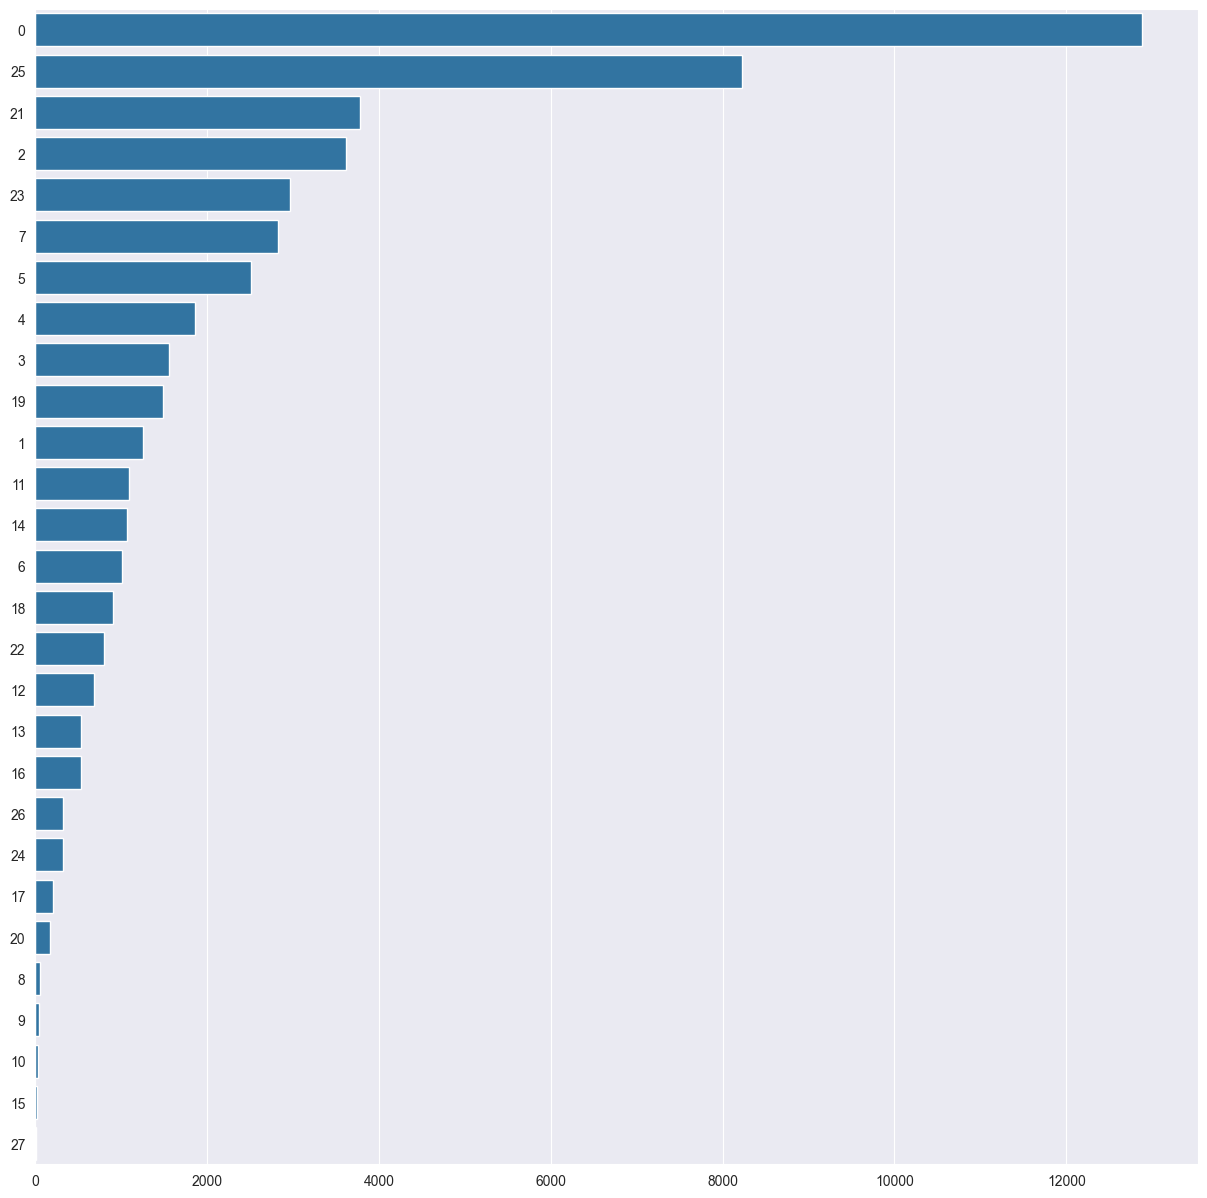

In [5]:
full_counts = train_df['Target'].apply(lambda r: r.split(' ')).explode().value_counts()
plt.figure(figsize=(15,15))
sns.barplot(y=full_counts.index.values, x=full_counts.values, order=full_counts.index)
plt.show()

The label distribution is highly uneven, indicating that the dataset is significantly imbalanced. Labels '0' (Nucleoplasm) and '25' (Cytosol) are vastly overrepresented, while labels '8', '9', '10', '15', and '27' (Peroxisomes, Endosomes, Lysosomes, Microtubule ends, and Rods & rings, respectively) are almost nonexistent.

Let's take a closer look at these two extremes.

In [6]:
print(full_counts.iloc[0])

12885


In [7]:
print(full_counts.iloc[27])

11


As we can see, the dataset is extremely unbalanced. This will be a critical factor to address when constructing our model.

Another important aspect to consider is the distribution of the number of labels per image.

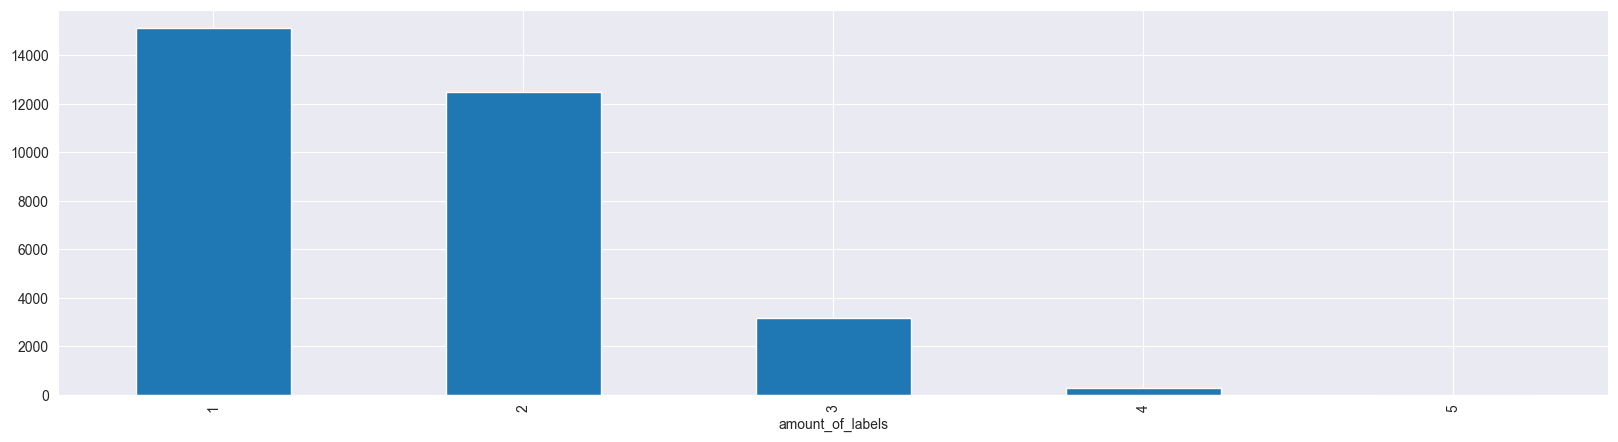

In [6]:
train_df['amount_of_labels'] = train_df['Target'].apply(lambda r: len(r.split(' ')))
plt.figure(figsize=(20,5))
train_df['amount_of_labels'].value_counts().plot.bar()
plt.show()

Great! Most images contain only one or two labels, which should help mitigate some of the challenges that could arise with the multi-label setting.

Naturally, this raises the question of label cooccurrence: how often do different labels appear together in the dataset? To explore this, we need to perform some preprocessing.

We will add a one hot encoding representation to our dataframe. specifically, we will add 28 columns - one for each label. For each entry, all columns will be set to 0, except those corresponding to labels present in the image, which will be set to 1. This will allow us to analyze label correlations effectively.

In [7]:
train_df["Target_list"] = train_df["Target"].apply(lambda x: list(map(int, x.split())))

def add_one_hot_encoding(row):
    target_list = row["Target_list"]
    for num in np.atleast_1d(target_list):
        name = INDEX_TO_LABEL[int(num)]
        row.loc[name] = 1
    return row

In [8]:
for key in INDEX_TO_LABEL.keys():
    train_df[INDEX_TO_LABEL[key]] = 0

In [9]:
train_df = train_df.apply(add_one_hot_encoding, axis=1)

Let's take a look at the updated structure of the dataframe after adding the one-hot encoded columns:

In [10]:
train_df.head(5)

,Id,Target,amount_of_labels,Target_list,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0,2,"[16, 0]",1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0,4,"[7, 1, 2, 0]",1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5,1,[5],0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1,1,[1],0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18,1,[18],0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


Now, let's calculate the cooccurrence matrix itself:

In [13]:
cooccurrence_matrix = train_df[train_df.amount_of_labels > 1].drop(["Id", "Target", "Target_list", "amount_of_labels"], axis=1).corr()

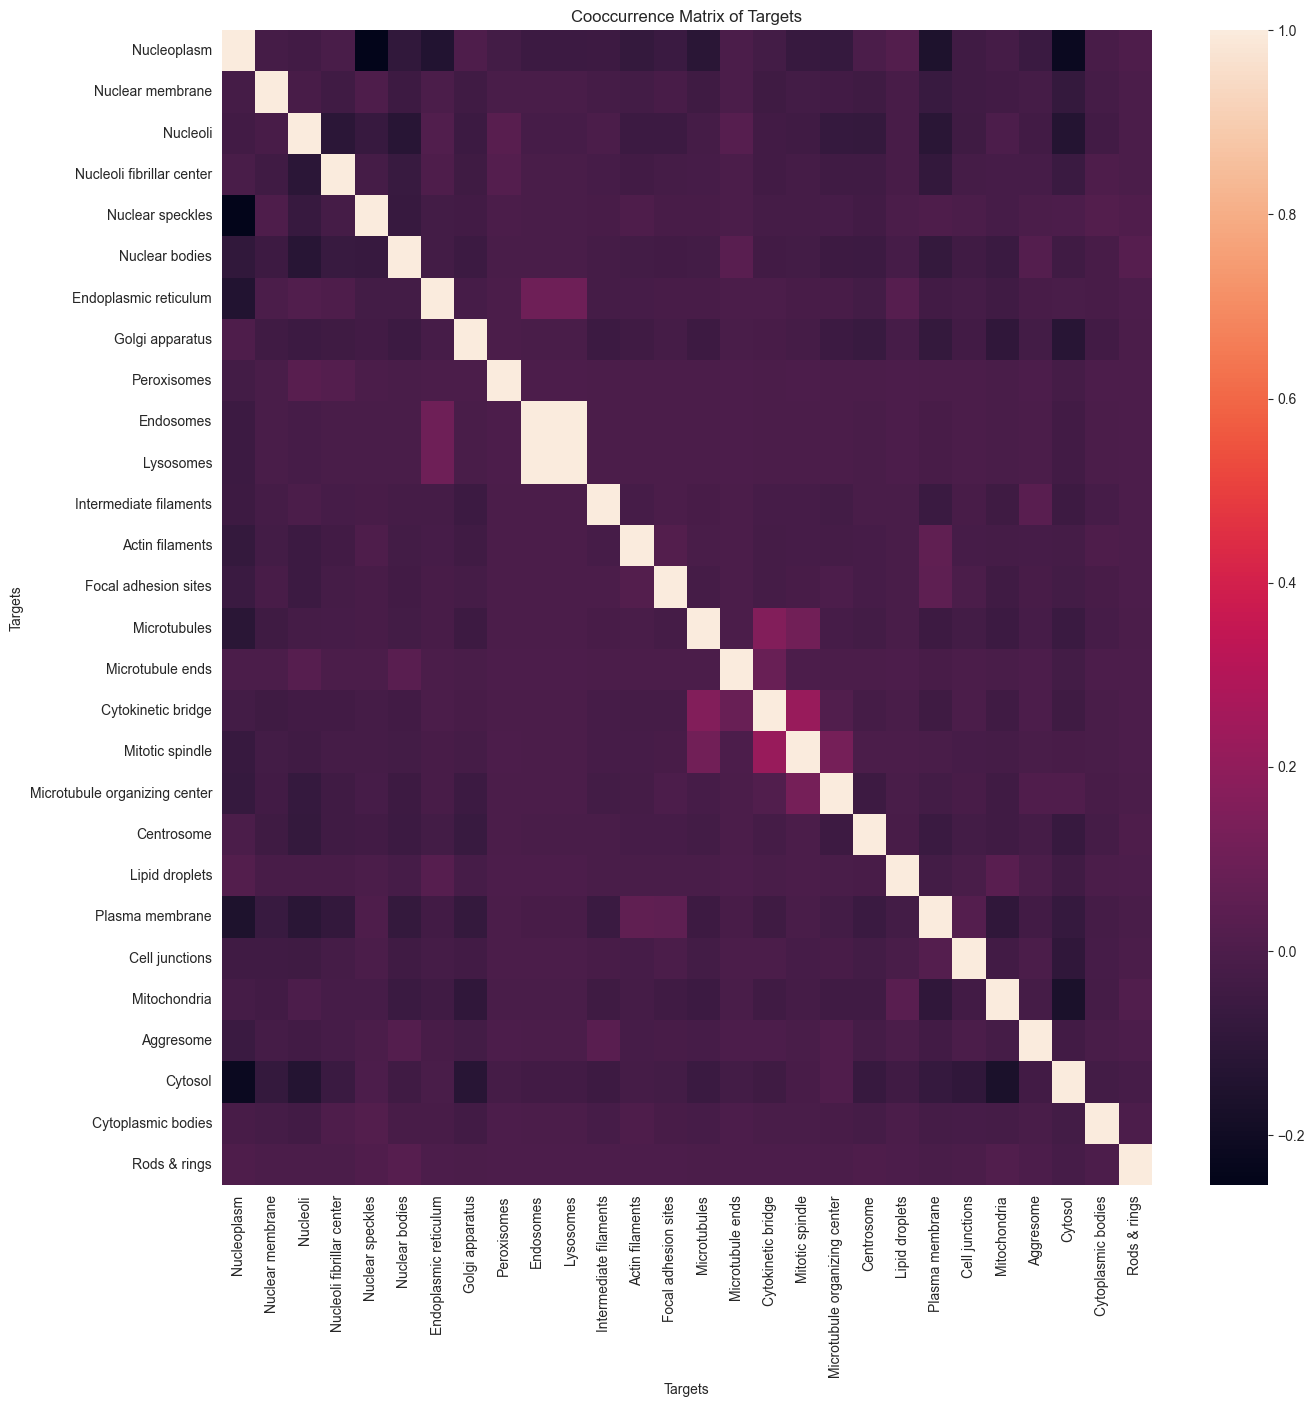

In [14]:
plt.figure(figsize=(15, 15))
sns.heatmap(cooccurrence_matrix)
plt.title("Cooccurrence Matrix of Targets")
plt.xlabel("Targets")
plt.ylabel("Targets")
plt.show()

Hmm, we can see that most of the labels are uncorrelated, except for Lysosomes and Endosomes (10 and 9 respectfully) that are grouped.

### visualising the images

Up to this point, we've only explored abstract metadata about the dataset. We haven't yet examined the actual image data!

To address this, we will define some useful functions for loading and displaying images. These will help us better visualize and understand the dataset.

In [11]:
def load_image(image_id, size=(512, 512), channels_to_drop=None):
    if channels_to_drop is None:
        channels_to_drop = []

    green  = cv.imread(os.path.join(TRAIN_PATH, image_id + "_green.png"),  cv.IMREAD_GRAYSCALE)
    red    = cv.imread(os.path.join(TRAIN_PATH, image_id + "_red.png"),    cv.IMREAD_GRAYSCALE)
    blue   = cv.imread(os.path.join(TRAIN_PATH, image_id + "_blue.png"),   cv.IMREAD_GRAYSCALE)
    yellow = cv.imread(os.path.join(TRAIN_PATH, image_id + "_yellow.png"), cv.IMREAD_GRAYSCALE)

    green  = cv.resize(green,  size)
    red    = cv.resize(red,    size)
    blue   = cv.resize(blue,   size)
    yellow = cv.resize(yellow, size)

    full_image = [green, red, blue, yellow]
    image_filtered = [ch for i, ch in enumerate(full_image) if i not in channels_to_drop]

    image_filtered = np.stack(image_filtered, axis=0).astype(np.float32) / 255.0
    return image_filtered

In [12]:
def display_4_channels(image, image_label, space_between_rows = 0.0):

    channel_titles = [
        "Protein of Interest",
        "Microtubules",
        "Nucleus",
        "Endoplasmic Reticulum",
    ]

    fig, ax = plt.subplots(2,2, figsize=(12, 12))
    fig.suptitle(f"Label: {image_label}", fontsize=16)
    ax[0][0].imshow(image[0], cmap="Greens")
    ax[0][0].set_title(channel_titles[0], fontsize=10)

    ax[0][1].imshow(image[1], cmap="Reds")
    ax[0][1].set_title(channel_titles[1], fontsize=10)

    ax[1][0].imshow(image[2], cmap="Blues")
    ax[1][0].set_title(channel_titles[2], fontsize=10)

    ax[1][1].imshow(image[3], cmap="YlOrBr")
    ax[1][1].set_title(channel_titles[3], fontsize=10)

    plt.subplots_adjust(hspace = space_between_rows)
    plt.show()
    return

In [13]:
def get_image_with_label(label_name, dataframe, size=(256,256)):

    if label_name not in dataframe.columns:
        print(f"Label '{label_name}' is not a valid column in the dataframe.")
        return None

    filtered_df = dataframe[(dataframe[label_name] == 1)]

    if filtered_df.empty:
        print(f"No rows found with only the label '{label_name}'.")
        return None

    random_row = filtered_df.sample(n=1).iloc[0]

    image = load_image(random_row["Id"], size)

    return image

Great! Now we can visualize the data based on its labels. We will showcase only a selection of the 28 classes, as displaying all of them would be quite lengthy.

We will start with the most common label, the Nucleoplasm.

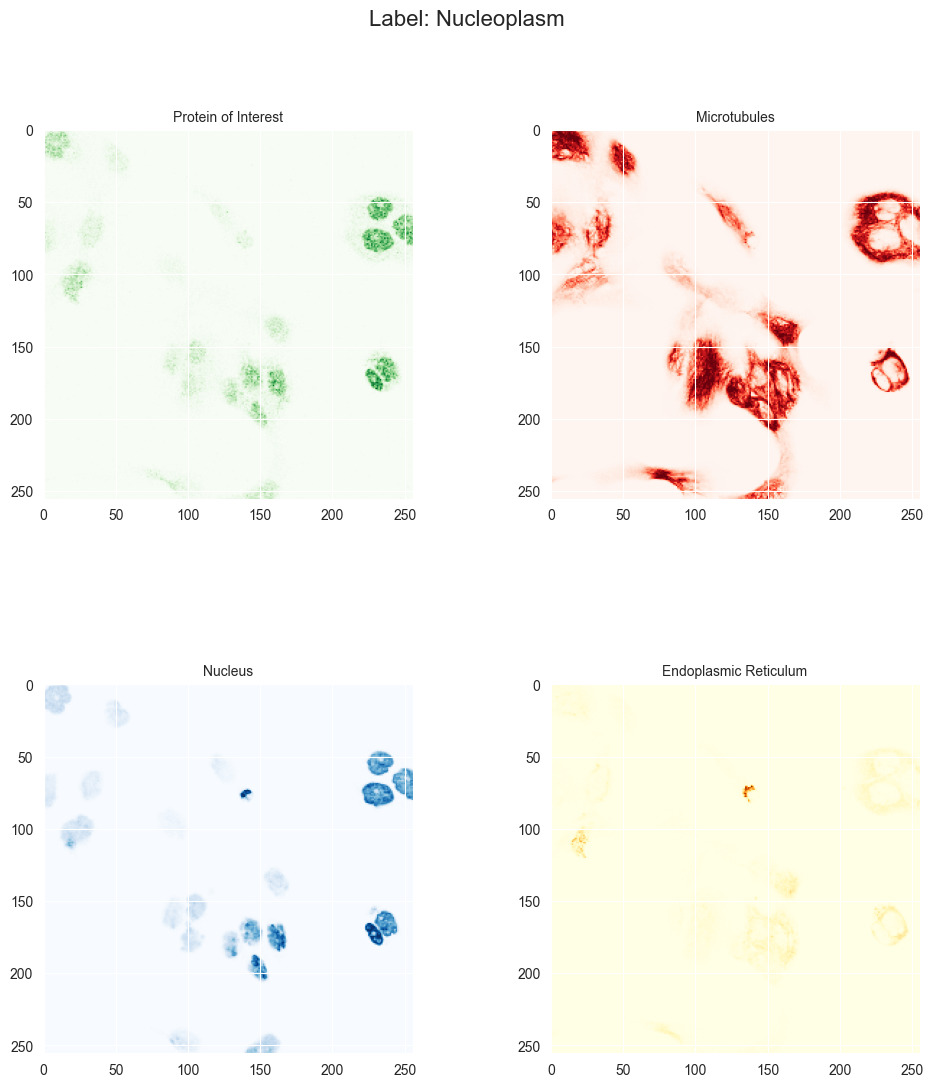

In [16]:
nuc_image = get_image_with_label('Nucleoplasm', train_df)

display_4_channels(nuc_image, image_label="Nucleoplasm", space_between_rows= 0.5)

The Nucleoplasm is a gel-like substance that fills the space of the nucleus. It is vital for many important biological processes, and it is also responsible for maintaining the shape of the nucleus.

In the image, we can observe a strong correlation between the green and blue channels, which is consistent with the nucleoplasm's properties we described above.

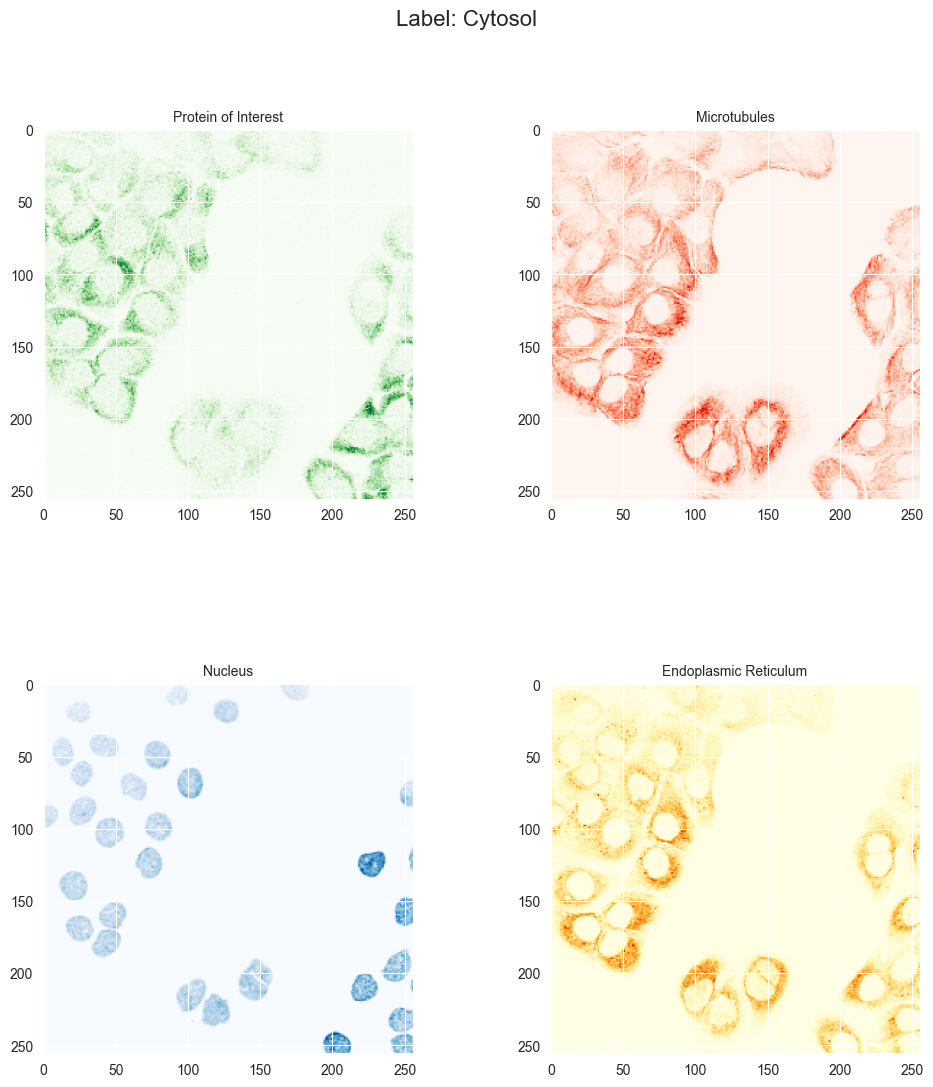

In [22]:
Cytosol_image = get_image_with_label('Cytosol', train_df)

display_4_channels(Cytosol_image, image_label="Cytosol", space_between_rows= 0.5)


The Cytosol is also a gel-like substance that fills the space of the cell. It is essential for many important biological processes, such as energy production, protein synthesis, and the transport of molecules within the cell. The cytosol also helps maintain the overall shape of the cell by providing structural support.

In the image, we can observe a correlation of the green channel with the red and yellow, and an inverse correlation with the blue. Which is consistent with what we wouldv'e expected.

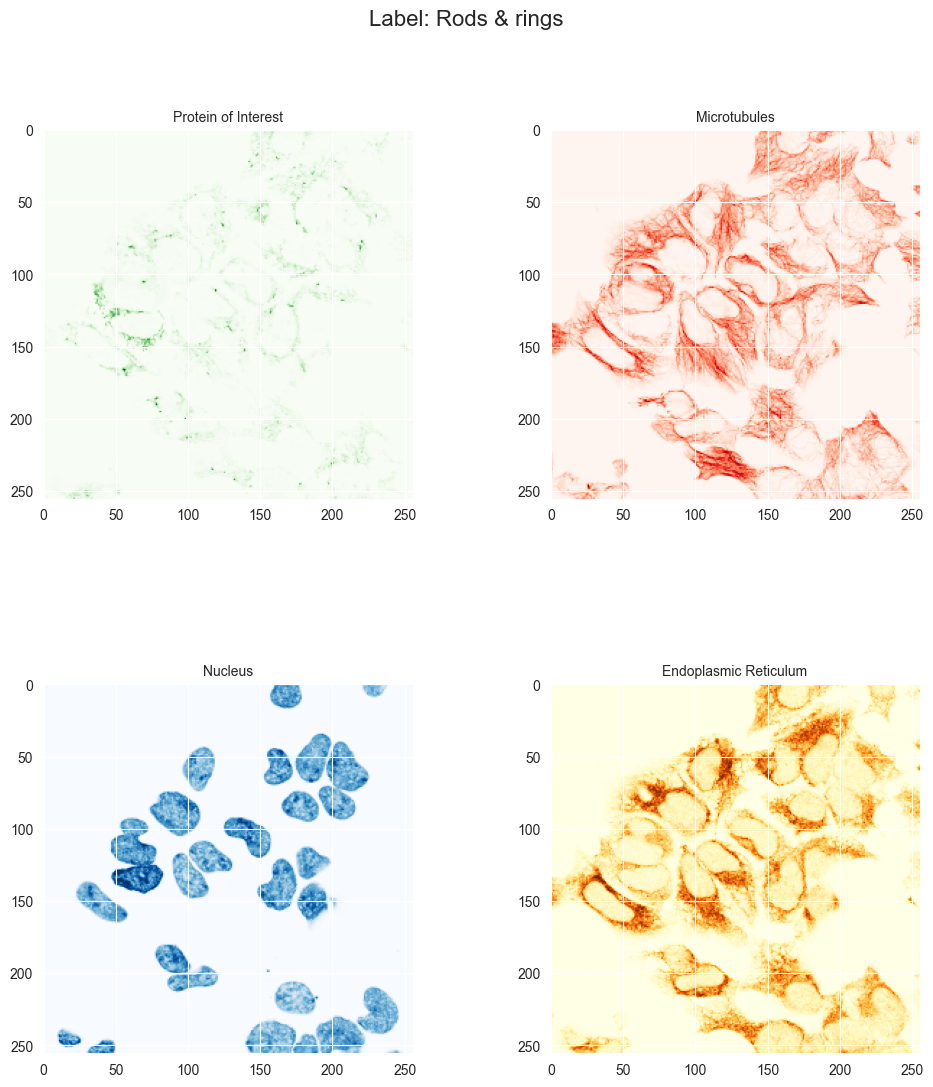

In [222]:
nuc_image = get_image_with_label('Rods & rings', train_df)

display_4_channels(nuc_image, image_label='Rods & rings', space_between_rows= 0.5)


Rods and Rings are structures that can form in the in the cytosol under specific conditions. They are composed of proteins involved in nucleotide metabolism. These structures are associated with cellular responses to metabolic stress and can appear in cells treated with certain drugs or under specific disease conditions. this can explain their rarity in the dataset.

In the image, we can observe that the green channel is mainly present around the nucleus, which is the region of the Cytosol as we wouldv'e expected.

Although not comprehensive (for that - https://www.proteinatlas.org/learn/dictionary#cell), we hope this brief exploration of the patterns in the dataset has provided useful intuition about the challenge. Now, let's begin tackling it!

# Baseline - CNN


For our baseline model, we will use a classic approach: a Convolutional Neural Network (CNN).

To implement this model, we will use TensorFlow with the Keras interface for convenience.

We will evaluate the model using the F1 metric, as it is the standard metric for this competition.

Additionally, we will use a confusion table to assess the algorithm's performance on single-label entries. While another option is to compute 28 individual confusion matrices (one for each label), we decided that focusing on single-label data is the most intuitive approach, given that a large fraction of the dataset consists of single-label images anyway.

As usual, we will begin by importing the necessary libraries.

## Training

In [15]:
import os
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

2025-01-11 18:05:25.044372: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-11 18:05:25.057699: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8473] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-11 18:05:25.061541: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1471] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 18:05:25.071400: I tensorflow/core/platform/cpu_feature_guard.cc:211] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Next, we will generate a one-hot encoded matrix for the training and testing process.

In [16]:
multi_label_columns = [INDEX_TO_LABEL[i] for i in range(28)]

one_hot_matrix = train_df[multi_label_columns].values.astype(np.float32)

print("One-hot shape:",one_hot_matrix.shape)

One-hot shape: (31072, 28)


In [17]:
single_label_df = train_df[train_df["amount_of_labels	"] == 1].copy()

In [18]:
train_df.head()

,Id,Target,amount_of_labels,Target_list,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0,2,"[16, 0]",1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0,4,"[7, 1, 2, 0]",1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5,1,[5],0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1,1,[1],0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18,1,[18],0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


Now, we can perform the train-test split.

We will divide the available data into three groups: train, val, and test.

- train: will be used for the gradient descent process.

- validation (val): will be used to optimize the training process, such as tuning hyperparameters and preventing overfitting.

- test: will be used for evaluating the final performance of the model.

In [39]:
from sklearn.model_selection import train_test_split

train_val_ids, test_ids, y_train_val, y_test = train_test_split(
    train_df["Id"].values,
    one_hot_matrix,
    test_size=0.1,
    random_state=42,
    stratify=None
)

train_ids, val_ids, y_train, y_val = train_test_split(
    train_val_ids,
    y_train_val,
    test_size=0.2,
    random_state=42,
    stratify=None
)

print(f"Train size: {len(train_ids)}")
print(f"Val size:   {len(val_ids)}")
print(f"Test size:  {len(test_ids)}")


Train size: 22371
Val size:   5593
Test size:  3108


It would be useful to have the ability to drop specific channels when loading the images. This will allow us to focus only on the channels we want to our analysis.

In [19]:
def load_image(image_id, img_dir, size=(256, 256), channels_to_drop=None):
    if channels_to_drop is None:
        channels_to_drop = []

    green  = cv.imread(os.path.join(img_dir, image_id + "_green.png"),  cv.IMREAD_GRAYSCALE)
    red    = cv.imread(os.path.join(img_dir, image_id + "_red.png"),    cv.IMREAD_GRAYSCALE)
    blue   = cv.imread(os.path.join(img_dir, image_id + "_blue.png"),   cv.IMREAD_GRAYSCALE)
    yellow = cv.imread(os.path.join(img_dir, image_id + "_yellow.png"), cv.IMREAD_GRAYSCALE)

    green  = cv.resize(green,  size)
    red    = cv.resize(red,    size)
    blue   = cv.resize(blue,   size)
    yellow = cv.resize(yellow, size)

    full_image = [green, red, blue, yellow]
    image_filtered = [ch for i, ch in enumerate(full_image) if i not in channels_to_drop]

    image_filtered = np.stack(image_filtered, axis=0).astype(np.float32) / 255.0
    return image_filtered

To make the training and testing processes more efficient (and to prevent memory overload), it may be wise to build a data generator that loads and prepares batches of images on the fly.

We will use the tf.keras.utils.Sequence class, which integrates well with the rest of the Keras interface. This will also make the training process more efficient and will save us from a lot of boring and repetitive work.

Additionally, we will add shuffling at the end of each epoch. This will prevent overfitting by ensuring that the model does not memorize the order of the data. It will also mitigate biases in the batch composition, which is particularly important given the dataset's class imbalance.

In [41]:
class MultiLabelDataGenerator(tf.keras.utils.Sequence):
    def __init__(
        self,
        ids,
        labels,
        img_dir,
        batch_size=8,
        size=(256, 256),
        channels_to_drop=None,
        shuffle=True
    ):
        self.ids = ids
        self.labels = labels
        self.img_dir = img_dir
        self.batch_size = batch_size
        self.size = size
        self.channels_to_drop = channels_to_drop if channels_to_drop else []
        self.shuffle = shuffle

        self.indices = np.arange(len(self.ids))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.ids) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_indices = self.indices[start:end]

        channels = 4 - len(self.channels_to_drop)

        X_batch = np.zeros((len(batch_indices), channels, self.size[1], self.size[0]), dtype=np.float32)
        y_batch = np.zeros((len(batch_indices), NUM_CLASSES), dtype=np.float32)

        for i, idx in enumerate(batch_indices):
            image_id = self.ids[idx]
            X_batch[i] = load_image(image_id, self.img_dir, size=self.size, channels_to_drop=self.channels_to_drop)
            y_batch[i] = self.labels[idx]

        X_batch = np.transpose(X_batch, (0, 2, 3, 1))

        return X_batch, y_batch

Now we can build the model itself. We will use a simple architecture:

1. Input Layer.

2. Convolutional Layer + Max Pooling Layer (repeated 3 times).
    
3. Flattening Layer.
    
4. Dense Fully Connected Layer.

5. Dropout Layer.
    
6. Output Dense Layer with a sigmoid activation function.

For optimization, we will use the Adam optimizer, which was first proposed in 2015 by Diederik P. Kingma and Jimmy Ba. We won't get into the details (for that -  https://arxiv.org/pdf/1412.6980), but in short, Adam dynamically adjusts the learning rate for each parameter, offering great efficiency and robustness. This should (hopefully) help make our model more powerful.

Finally, we will use the BCE loss function, the standard choice for such tasks.

In [42]:
def build_multi_label_cnn(input_shape=(256,256,4), lr=1e-4):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2,2)),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),

        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),

        Dense(NUM_CLASSES, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

Now we can create the data generators for each data class. We will use a small batch size of 8 to ensure memory stability during the training process. Additionally, due to hardware constraints, we will resize the images to 256×256.

As stated earlier, we will apply shuffling to the training data to improve generalization.

In [43]:
BATCH_SIZE = 8
CHANNELS_TO_DROP = []
model_input_channels = 4 - len(CHANNELS_TO_DROP)
model_input_shape = (256, 256, model_input_channels)

train_gen = MultiLabelDataGenerator(
    ids=train_ids,
    labels=y_train,
    img_dir=TRAIN_PATH,
    batch_size=BATCH_SIZE,
    size=(256,256),
    channels_to_drop=CHANNELS_TO_DROP,
    shuffle=True
)

val_gen = MultiLabelDataGenerator(
    ids=val_ids,
    labels=y_val,
    img_dir=TRAIN_PATH,
    batch_size=BATCH_SIZE,
    size=(256,256),
    channels_to_drop=CHANNELS_TO_DROP,
    shuffle=False
)

test_gen = MultiLabelDataGenerator(
    ids=test_ids,
    labels=y_test,
    img_dir=TRAIN_PATH,
    batch_size=BATCH_SIZE,
    size=(256,256),
    channels_to_drop=CHANNELS_TO_DROP,
    shuffle=False
)

model = build_multi_label_cnn(input_shape=model_input_shape)
model.summary()


C:\Users\ganda\PycharmProjects\PythonProject\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 28)             │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,842,876 (56.62 MB)

 Trainable params: 14,842,876 (56.62 MB)

 Non-trainable params: 0 (0.00 B)

Now we can start the training process itself!

We will train the model for 5 epochs and use model checkpoints to save the model during training. This will protect our model from issues such as overfitting or unexpected interruptions (We had to learn it the hard way...).

To gain insights on the training process, we will also save the loss at the end of each epoch.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

EPOCHS = 5

model_checkpoint_cb = ModelCheckpoint(
    filepath="CNN_3_checkpoint_epoch_{epoch:02d}_val_loss{val_loss:.4f}.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

early_stopping_cb = EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor="val_loss",
    verbose=1
)

callbacks_list = [model_checkpoint_cb, early_stopping_cb]
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=callbacks_list
)

history_df = pd.DataFrame(history.history)
history_df.to_csv("training_history_CNN.csv", index=False)

print("Training complete. History saved to 'training_history_CNN.csv'.")

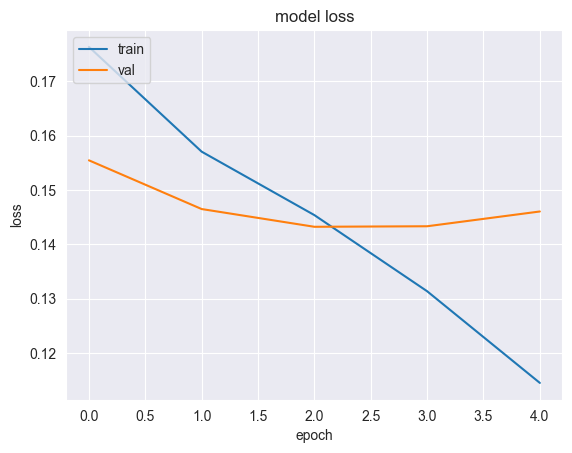

In [112]:
CNN_history_df = pd.read_csv("training_history_CNN.csv")

plt.plot(CNN_history_df['loss'])
plt.plot(CNN_history_df['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

It appears that the model started overfitting at some point. Fortunately, we can still use the best version of the model thanks to the checkpoint system.

## Evaluation

Now we can evaluate the model!

In [184]:
test_preds = model.predict(test_gen)
test_true = y_test

C:\Users\ganda\PycharmProjects\PythonProject\.venv\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 21 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\ganda\PycharmProjects\PythonProject\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


389/389 ━━━━━━━━━━━━━━━━━━━━ 54s 138ms/step


To calculate the F1 score, we need to convert the probabilities into predictions. This requires deciding on a threshold probability. We will start with an arbitrary threshold of 0.5.

In [185]:
threshold = 0.5
test_preds_binary = (test_preds >= threshold).astype(int)

f1_multi_label = f1_score(test_true, test_preds_binary, average="samples")
print("Multi-label F1 score (samples average):", f1_multi_label)


Multi-label F1 score (samples average): 0.3475117975117975


Hmm, this seems fine for a baseline.

On the other hand, we might be able to achieve better results simply by tweaking the threshold value.

### Dynamic Thresholding

Our approach will be to iteratively find the best uniform threshold value that maximizes the macro F1 score.

In other words, we will use a simple linear search algorithm.

In [20]:
def find_best_global_threshold(y_true, y_proba, step=0.001, average="samples"):

    best_threshold = 0.5
    best_f1 = 0.0

    for thr in np.arange(0.0, 1.0 + step, step):
        y_pred_bin = (y_proba >= thr).astype(int)

        f1_val = f1_score(y_true, y_pred_bin, average=average, zero_division=0)

        if f1_val > best_f1:
            best_f1 = f1_val
            best_threshold = thr

    return best_threshold, best_f1

In [ ]:
best_thr, best_f1 = find_best_global_threshold(test_true, test_preds, step=0.01, average="samples")

print("Best global threshold:", best_thr)
print("Best multi-label F1 (samples):", best_f1)

Best global threshold: 0.17
Best multi-label F1 (samples): 0.493607250750108


Wow! We achieved a 0.15 boost to our F1 score simply by adjusting the threshold.

This suggests that fine tuning the threshold might be a promising direction for achieving even better results.

### Differential Thresholding

The previous approach wasn't bad, but it was certainly not optimal. The threshold it computed was the same for all labels.

What if the optimal threshold values differ for each label? It's reasonable to assume that for rarer labels, the model might be less confident, requiring lower thresholds to make accurate predictions. In this case, the threshold would become a vector of length 28, with a separate value for each label.

To improve, we'll take a different approach: instead of maximizing the F1 score for all labels together, we will optimize it individually for each label. This involves tweaking each label's threshold independently until we reach its optimal value.

In [188]:
def find_best_thresholds_per_label(y_true, y_proba, step=0.001):

    num_labels = y_true.shape[1]
    best_thresholds = np.zeros(num_labels)

    for i in range(num_labels):
        best_thr_for_label = 0.5
        best_f1_for_label = 0.0

        for thr in np.arange(0.0, 1.0 + step, step):

            y_pred_bin = (y_proba[:, i] >= thr).astype(int)
            f1_i = f1_score(y_true[:, i], y_pred_bin, zero_division=0)

            if f1_i > best_f1_for_label:
                best_f1_for_label = f1_i
                best_thr_for_label = thr

        best_thresholds[i] = best_thr_for_label

    return best_thresholds

In [37]:
best_thresholds = find_best_thresholds_per_label(test_true, test_preds, step=0.01)
print("Best thresholds per label:\n", best_thresholds)

Best thresholds per label:
 [0.52 0.09 0.25 0.23 0.16 0.15 0.13 0.16 0.04 0.01 0.01 0.07 0.08 0.09
 0.22 0.   0.05 0.05 0.07 0.13 0.03 0.4  0.11 0.21 0.08 0.3  0.05 0.5 ]


Alright! now time for evaluation.

In [38]:
test_predictions_bin = np.zeros_like(test_preds, dtype=int)
for i in range(NUM_CLASSES):
    test_predictions_bin[:, i] = (test_preds[:, i] >= best_thresholds[i]).astype(int)

In [39]:
final_f1 = f1_score(test_true, test_predictions_bin, average="samples", zero_division=0)
print("Final multi-label F1 at best_thr:", final_f1)


Final multi-label F1 at best_thr: 0.37249145662458355


Hmm, as is clearly seen, this approach didn't work out as well as we had hoped. This is likely because our optimization was done for each label individually, rather than considering the overall F1 score.

An interesting approach for the future would be to use some form of gradient descent algorithm to find the optimal threshold vector. Since the F1 function is not differentiable, this would not be straightforward, but it is an interesting direction to explore nonetheless.

### Confusion matrix

We will evaluate the model's performance using a confusion matrix for single-label entries.

In [189]:
test_single_label_df = single_label_df[single_label_df["Id"].isin(test_ids)].copy()
print(f"Single-label images in test set: {len(test_single_label_df)}")

Single-label images in test set: 1559


We should  note that this dataset is relatively small, so the model's performance is likely to be more sensitive to the size of each label in the new distribution.

In [190]:
test_single_ids = test_single_label_df["Id"].values
test_single_labels = np.zeros((len(test_single_label_df), NUM_CLASSES), dtype=np.float32)

for i, row in test_single_label_df.iterrows():
    for lbl in row["Target_list"]:
        test_single_labels[np.where(test_single_ids == row["Id"])[0], lbl] = 1.0

In [191]:
test_single_gen = MultiLabelDataGenerator(
    ids=test_single_ids,
    labels=test_single_labels,
    img_dir=TRAIN_PATH,
    batch_size=BATCH_SIZE,
    size=(256,256),
    channels_to_drop=CHANNELS_TO_DROP,
    shuffle=False
)

And for the prediction itself:

In [192]:
single_label_preds = model.predict(test_single_gen)

C:\Users\ganda\PycharmProjects\PythonProject\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


195/195 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step


In [193]:
predicted_indices = np.argmax(single_label_preds, axis=1)
true_indices = np.argmax(test_single_labels, axis=1)

cm = confusion_matrix(true_indices, predicted_indices, labels = np.arange(NUM_CLASSES))
f1_sl = f1_score(true_indices, predicted_indices, average='macro', zero_division=0)

print("Single-label F1:", f1_sl)

Single-label F1: 0.13850859193239354


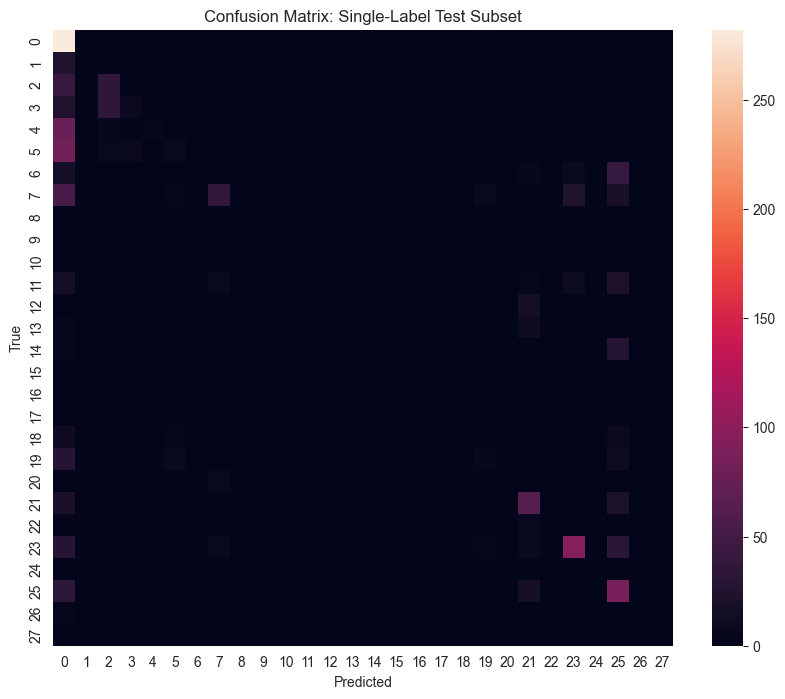

In [194]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt='d')
plt.title("Confusion Matrix: Single-Label Test Subset")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Not bad for a simple baseline.

There is a subtle diagonal pattern, with an obvious bias toward more frequent classes, namely '25' and '0'.

Nevertheless, we will try to further enhance our approach.

# Reducing channels approach

As noted by the competition hosts, the green channel contains the most critical information. Additionally, it appears to have the least entropy, which might contribute to better prediction results.

For this reason, we will drop the red and yellow channels, retaining only the green channel (as the primary information) and the blue channel (as a reference).

Our new model will follow the same architecture as before, except that we will exclude the red and yellow channels and use the original image size.

In [198]:
def build_multi_label_cnn(input_shape=(512,512,2), lr=1e-4):

    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2,2)),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),

        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),

        Dense(NUM_CLASSES, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [199]:
from sklearn.model_selection import train_test_split

train_val_ids, test_ids, y_train_val, y_test = train_test_split(
    train_df["Id"].values,
    one_hot_matrix,
    test_size=0.1,
    random_state=42,
    stratify=None
)

train_ids, val_ids, y_train, y_val = train_test_split(
    train_val_ids,
    y_train_val,
    test_size=0.2,
    random_state=42,
    stratify=None
)

print(f"Train size: {len(train_ids)}")
print(f"Val size:   {len(val_ids)}")
print(f"Test size:  {len(test_ids)}")


Train size: 22371
Val size:   5593
Test size:  3108


In [203]:
BATCH_SIZE = 8

CHANNELS_TO_DROP = [1, 3]

model_input_channels = 4 - len(CHANNELS_TO_DROP)
model_input_shape = (512, 512, model_input_channels)

train_gen = MultiLabelDataGenerator(
    ids=train_ids,
    labels=y_train,
    img_dir=TRAIN_PATH,
    batch_size=BATCH_SIZE,
    size=SIZE_512,
    channels_to_drop=CHANNELS_TO_DROP,
    shuffle=True
)

val_gen = MultiLabelDataGenerator(
    ids=val_ids,
    labels=y_val,
    img_dir=TRAIN_PATH,
    batch_size=BATCH_SIZE,
    size=SIZE_512,
    channels_to_drop=CHANNELS_TO_DROP,
    shuffle=False
)

test_gen = MultiLabelDataGenerator(
    ids=test_ids,
    labels=y_test,
    img_dir=TRAIN_PATH,
    batch_size=BATCH_SIZE,
    size=SIZE_512,
    channels_to_drop=CHANNELS_TO_DROP,
    shuffle=False
)

model = build_multi_label_cnn(input_shape=model_input_shape)
model.summary()

C:\Users\ganda\PycharmProjects\PythonProject\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 510, 510, 32)   │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 255, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 253, 253, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 124, 124, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 492032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │    62,980,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 28)             │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,076,796 (240.62 MB)

 Trainable params: 63,076,796 (240.62 MB)

 Non-trainable params: 0 (0.00 B)

And the training process:

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_checkpoint_cb = ModelCheckpoint(
    filepath="CNN_2ch_checkpoint_{epoch:02d}_{val_loss:.4f}.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

early_stopping_cb = EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor="val_loss",
    verbose=1
)

callbacks_list = [model_checkpoint_cb, early_stopping_cb]


history = model.fit(
    train_gen,
    epochs=5,
    validation_data=val_gen,
    callbacks=callbacks_list
)

history_df = pd.DataFrame(history.histoary)
history_df.to_csv("training_history_2ch.csv", index=False)

print("Training complete. History saved to 'training_history_2ch.csv'.")


### Training progress

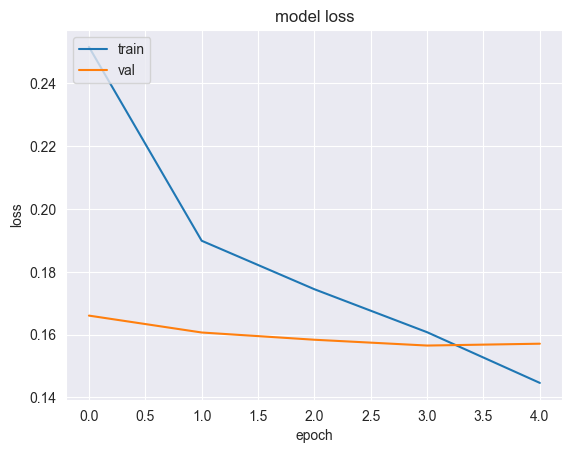

In [196]:
history_2ch_df = pd.read_csv("training_history_2ch.csv")

plt.plot(history_2ch_df['loss'])
plt.plot(history_2ch_df['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

Time to check whether the change was indeed productive.

In [201]:
#model.load_weights("CNN_2ch_checkpoint_04_0.1565.keras")

C:\Users\ganda\PycharmProjects\PythonProject\.venv\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 21 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [204]:
test_preds = model.predict(test_gen)
test_true = y_test

C:\Users\ganda\PycharmProjects\PythonProject\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


389/389 ━━━━━━━━━━━━━━━━━━━━ 135s 347ms/step


In [205]:
best_thr, best_f1 = find_best_global_threshold(test_true, test_preds, step=0.01, average="samples")

print("Best global threshold:", best_thr)
print("Best multi-label F1 (samples):", best_f1)

Best global threshold: 0.5
Best multi-label F1 (samples): 0.13472493441894245


Hmm, it seems the model performed worse. This suggests that the dropped channels may provide important context for the learning and prediction process, and their absence negatively impacts performance.

### Confusion matrix

In [208]:
test_single_ids = test_single_label_df["Id"].values
test_single_labels = np.zeros((len(test_single_label_df), NUM_CLASSES), dtype=np.float32)

for i, row in test_single_label_df.iterrows():
    for lbl in row["Target_list"]:
        test_single_labels[np.where(test_single_ids == row["Id"])[0], lbl] = 1.0

test_single_gen = MultiLabelDataGenerator(
    ids=test_single_ids,
    labels=test_single_labels,
    img_dir=TRAIN_PATH,
    batch_size=BATCH_SIZE,
    size=SIZE_512,
    channels_to_drop=CHANNELS_TO_DROP,
    shuffle=False
)


And for the prediction itself:


In [209]:
single_label_preds = model.predict(test_single_gen)
predicted_indices = np.argmax(single_label_preds, axis=1)
true_indices = np.argmax(test_single_labels, axis=1)

cm = confusion_matrix(true_indices, predicted_indices, labels=np.arange(NUM_CLASSES))
f1_sl = f1_score(true_indices, predicted_indices, average='macro', zero_division=0)

print("Single-label F1:", f1_sl)

C:\Users\ganda\PycharmProjects\PythonProject\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


195/195 ━━━━━━━━━━━━━━━━━━━━ 69s 352ms/step
Single-label F1: 0.018070804974001237


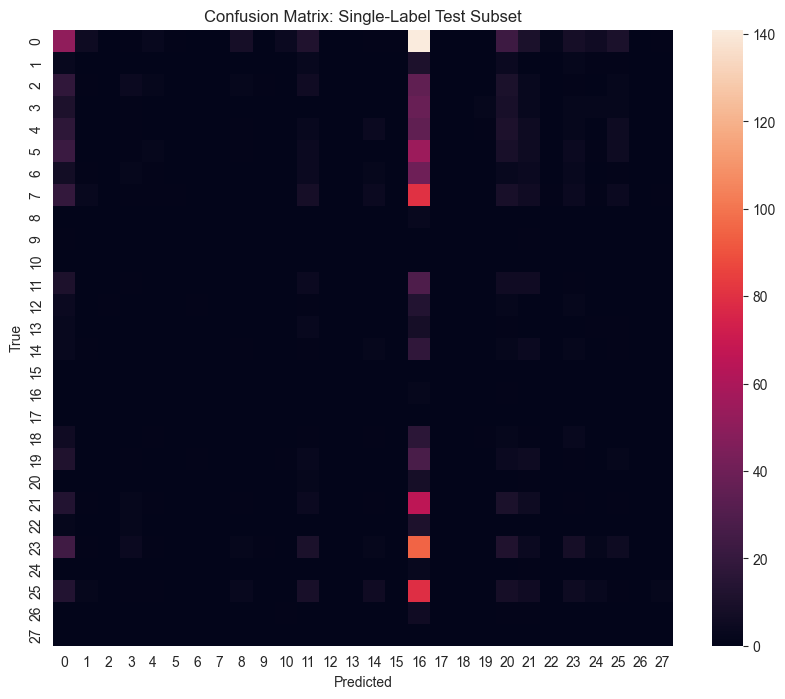

In [210]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt='d')
plt.title("Confusion Matrix: Single-Label Test Subset")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Interesting pattern. Let's analyze it. First, we can clearly see a bias toward label 16 - "Cytokinetic bridge".

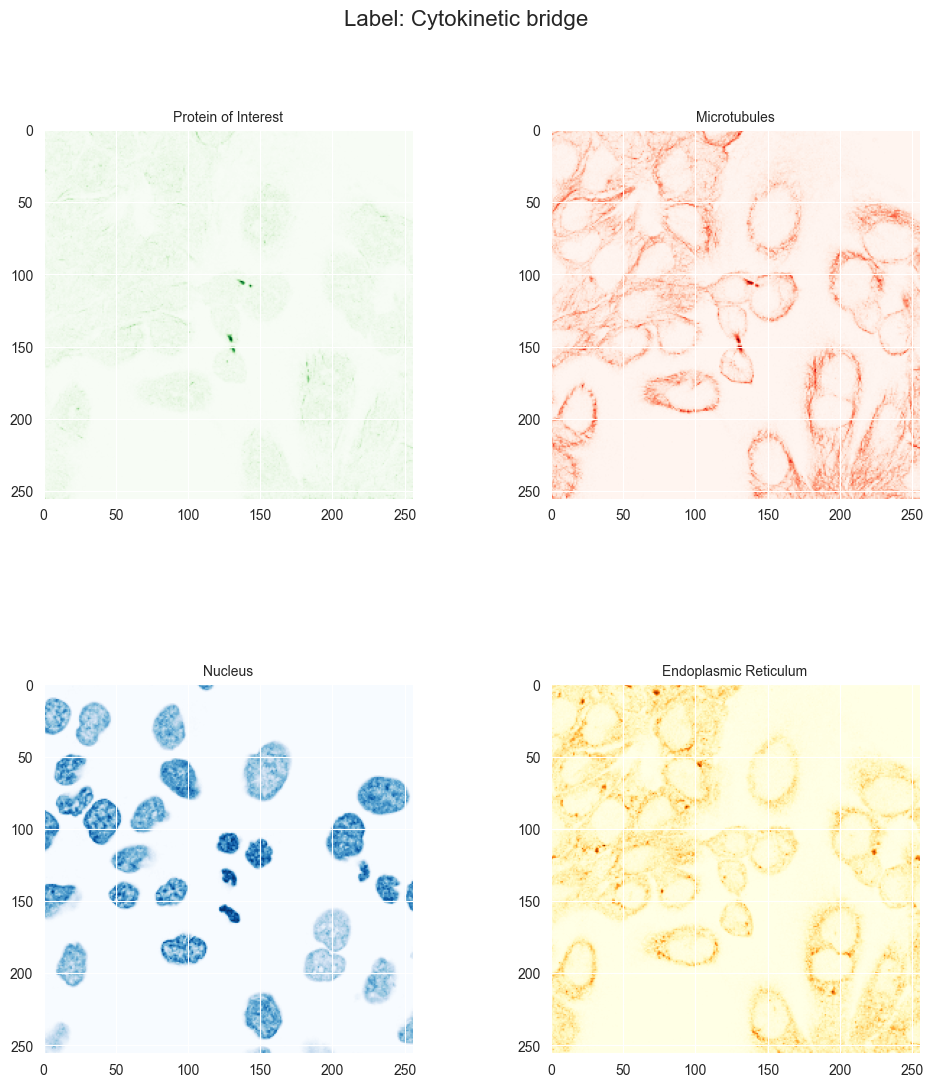

In [25]:
CB_image = get_image_with_label('Cytokinetic bridge', train_df)

display_4_channels(CB_image, image_label="Cytokinetic bridge", space_between_rows= 0.5)


The Cytokinetic Bridge is a thin, microtubule-based structure that connects two daughter cells during the final stages of cell division. It is crucial for separating the two cells completely, ensuring that each daughter cell receives the proper cellular contents and genetic material.

In the image, we can observe such structure in the green channel. It is important to note that by generating this image multiple times, there seems to be high variance in the green channel patterns.

In [29]:
print(f"amount of Cytokinetic bridge entries: {full_counts.iloc[16]}")

amount of Cytokinetic bridge entries: 688


As we can clearly see from the figure in the EDA section, label 16 is not one of the most common labels, so the bias doesn't stem from over-representation. While there is high variance in patterns, that doesn't fully explain the bias.

For now, we will stick with including the red channel in our model.

# Transfer Learning With Augmentations - ResNet50

Since the dataset is relatively small, it might be beneficial to use pre-trained models, a technique known as transfer learning. This approach involves using pre-trained weights, typically trained on a large, generic dataset. These pre-trained models provide basic filters for the CNN, such as edges and other simple features, which allows the model to focus on learning the specifics of our data, even with fewer training examples.

To further artificially increase the dataset and enhance generalization, we will use Data Augmentation. This technique applies transformations to the original data, creating new samples from it. Essentially, we are "doing more" with the same data. Data augmentation can also help reduce overfitting by introducing variations in the training set.

For implementation, we will use the ResNet architecture, which was proposed by Microsoft researchers in 2015 (link - https://arxiv.org/pdf/1512.03385, as of now, the paper was cited over 250,000 times). ResNet was designed to address the vanishing gradient problem that occurred in CNN architectures with a high number of layers.

In short, this architecture introduced "skip connections", which connect the activations of earlier layers directly to later layers, bypassing intermediate layers. While we won't delve into the details of why it works, these skip connections allow us to train much deeper networks effectively. For further reading (in a less formal manner than the original paper) - https://www.comet.com/site/blog/resnet-how-one-paper-changed-deep-learning-forever/.


Specifically, we will use the ResNet50 model (a 50 layer variant) with a few additional layers, including Global Average Pooling (GAP), dropout, and an output layer. For data augmentation, we will apply flips, rotations, and contrast transformations to further enhance generalization.

### Training

Again import statements:

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


Train-val-test split:

In [227]:
from sklearn.model_selection import train_test_split

train_val_ids, test_ids, y_train_val, y_test = train_test_split(
    train_df["Id"].values,
    one_hot_matrix,
    test_size=0.1,
    random_state=42,
    stratify=None
)

train_ids, val_ids, y_train, y_val = train_test_split(
    train_val_ids,
    y_train_val,
    test_size=0.2,
    random_state=42,
    stratify=None
)

print(f"Train size: {len(train_ids)}")
print(f"Val size:   {len(val_ids)}")
print(f"Test size:  {len(test_ids)}")


Train size: 22371
Val size:   5593
Test size:  3108


This is the model itself. We use ResNet50 as our base model and add:

- A GAP layer (instead of flattening and the first dense layers such as in the baseline CNN model).
    
- A dropout layer with a rate of 0.3 (which replaces the 0.5 of the last model, since the base ResNet model already mitigates some overfitting).

- The Adam optimizer and BCE loss, as before.

Additionally, we will resize the images to 224×224 because of the hardware limitations.

Since ResNet50 accepts only 3 channels, we will need to drop one. We chose to exclude the yellow channel, as the competition hosts noted that it is the least informative. Let's hope this choice does not negatively impact the model's performance.

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers

def build_resnet50_model(input_shape=(224,224,3), num_classes=28):

    base_model = ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='sigmoid', dtype='float32')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)

    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=opt,
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_resnet50_model(input_shape=(224, 224, 3), num_classes=NUM_CLASSES)
model.summary()

And a data generator with augmentations:

In [22]:
class MultiLabelDataGenerator(tf.keras.utils.Sequence):

    def __init__(
        self,
        ids,
        labels,
        img_dir,
        batch_size=8,
        size=(224, 224),
        channels_to_drop=None,
        shuffle=True,
        augment=False
    ):
        self.ids = ids
        self.labels = labels
        self.img_dir = img_dir
        self.batch_size = batch_size
        self.size = size 
        self.channels_to_drop = channels_to_drop if channels_to_drop else []
        self.shuffle = shuffle
        self.augment = augment

        self.indices = np.arange(len(self.ids))
        self.on_epoch_end()

        self.n_channels = 4 - len(self.channels_to_drop)

    def __len__(self):
        return int(np.ceil(len(self.ids) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_indices = self.indices[start:end]

        X_batch = np.zeros(
            (len(batch_indices), self.n_channels, self.size[1], self.size[0]),
            dtype=np.float32
        )
        y_batch = np.zeros((len(batch_indices), NUM_CLASSES), dtype=np.float32)

        for i, idx in enumerate(batch_indices):
            image_id = self.ids[idx]
            X_batch[i] = load_image(
                image_id,
                self.img_dir,
                size=self.size,
                channels_to_drop=self.channels_to_drop
            )
            y_batch[i] = self.labels[idx]

        X_batch = np.transpose(X_batch, (0, 2, 3, 1))

        if self.augment:
            X_batch_aug = np.zeros_like(X_batch)
            for i in range(len(X_batch)):
                X_batch_aug[i] = self.random_augment(X_batch[i])
            X_batch = X_batch_aug

        return X_batch, y_batch

    def random_augment(self, x):

        x_tf = tf.convert_to_tensor(x, dtype=tf.float32)

        k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
        x_tf = tf.image.rot90(x_tf, k=k)

        x_tf = tf.image.random_flip_left_right(x_tf)
        x_tf = tf.image.random_flip_up_down(x_tf)

        x_tf = tf.image.random_contrast(x_tf, lower=0.8, upper=1.2)

        return x_tf.numpy()


Building the data generators:

In [230]:
BATCH_SIZE = 8

train_gen = MultiLabelDataGenerator(
    ids=train_ids,
    labels=y_train,
    img_dir=TRAIN_PATH,
    batch_size=BATCH_SIZE,
    size=SIZE_224,
    channels_to_drop=[3], 
    shuffle=True,
    augment=True  
)

val_gen = MultiLabelDataGenerator(
    ids=val_ids,
    labels=y_val,
    img_dir=TRAIN_PATH,
    batch_size=BATCH_SIZE,
    size=SIZE_224,
    channels_to_drop=[3],
    shuffle=False,
    augment=False 
)

test_gen = MultiLabelDataGenerator(
    ids=test_ids,
    labels=y_test,
    img_dir=TRAIN_PATH,
    batch_size=BATCH_SIZE,
    size=SIZE_224,
    channels_to_drop=[3],
    shuffle=False
)

In [231]:
model = build_resnet50_model(input_shape=(224,224, 3), num_classes=NUM_CLASSES)


Finally, we can start the training! Since the model is pre-trained, we will train it for only 2 epochs.

In [ ]:
model_checkpoint_cb = ModelCheckpoint(
    filepath="0_resnet_checkpoint_epoch_{epoch:02d}_val_loss_{val_loss:.4f}.keras", 
    save_best_only=True,
    monitor="val_loss",      
    mode="min",              
    verbose=1
)

callbacks_list = [model_checkpoint_cb]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=2,
    verbose=1,
    callbacks = callbacks_list
    )
history_df = pd.DataFrame(history.history)
history_df.to_csv("0_resnet_training_history.csv", index=False)

print("Training complete. History saved to 'transfer_learning_with_augmentations_training_history.csv'.")


### Training progess

Because of Hardware limitations we trained for 2 epochs. anyway let's see the results:

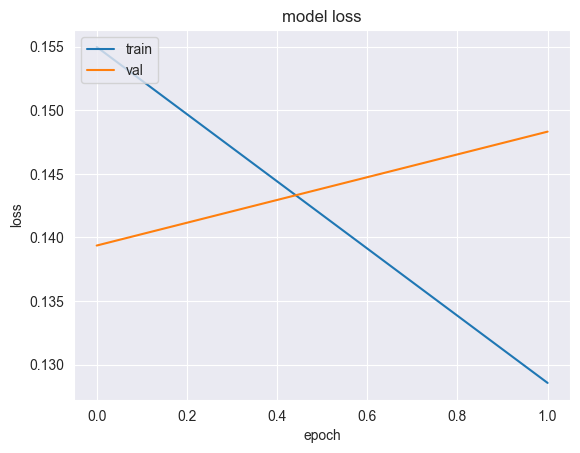

In [225]:
plt.plot(resnet_history_df['loss'])
plt.plot(resnet_history_df['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Alright, the model started to overfit after just one epoch. This suggests that limiting the training to 2 epochs was likely a reasonable choice.

### Evaluation

In [234]:
test_preds = model.predict(test_gen)
test_true = y_test

C:\Users\ganda\PycharmProjects\PythonProject\.venv\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 429 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


389/389 ━━━━━━━━━━━━━━━━━━━━ 241s 614ms/step


In [235]:
best_thr, best_f1 = find_best_global_threshold(test_true, test_preds, step=0.01, average="samples")

print("Best global threshold:", best_thr)
print("Best multi-label F1 (samples):", best_f1)
test_predictions_bin = (test_preds >= best_thr).astype(int)

Best global threshold: 0.25
Best multi-label F1 (samples): 0.5083890012461442


Seems good, we managed to pass the 0.5 line with smaller images.

### Confusion Matrix

In [239]:
test_single_label_df = single_label_df[single_label_df["Id"].isin(test_ids)].copy()
print(f"Single-label images in validation set: {len(test_single_label_df)}")


Single-label images in validation set: 1559


In [244]:
test_single_ids = test_single_label_df["Id"].values
test_single_labels = np.zeros((len(test_single_label_df), NUM_CLASSES), dtype=np.float32)

for i, row in test_single_label_df.iterrows():
    for lbl in row["Target_list"]:
        test_single_labels[np.where(test_single_ids == row["Id"])[0], lbl] = 1.0


test_single_gen = MultiLabelDataGenerator(
    ids=test_single_ids,
    labels=test_single_labels,
    img_dir=TRAIN_PATH,
    batch_size=BATCH_SIZE,
    size=SIZE_224,
    channels_to_drop=[3],
    shuffle=False
)

C:\Users\ganda\PycharmProjects\PythonProject\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


195/195 ━━━━━━━━━━━━━━━━━━━━ 117s 600ms/step
Single-label F1: 0.2575556505533806


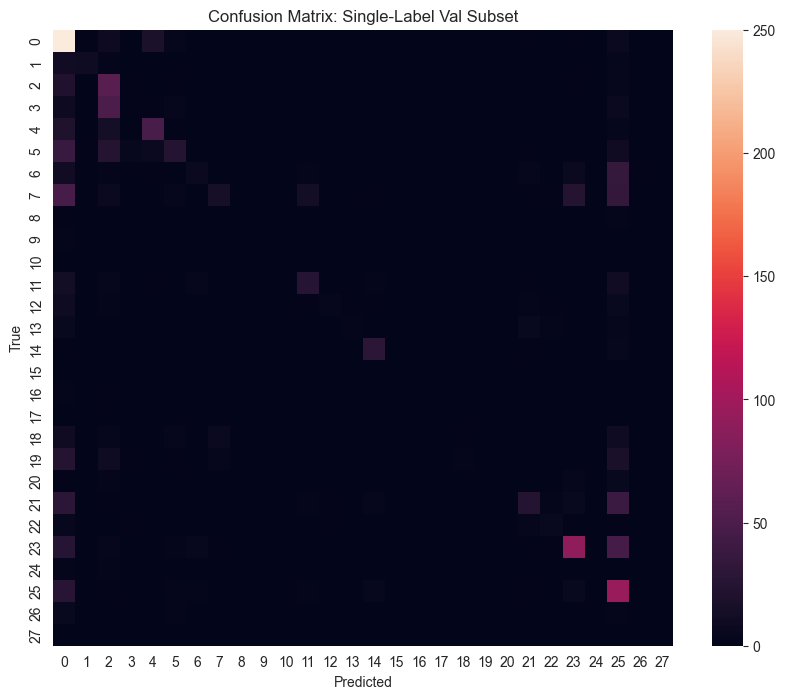

In [245]:
single_label_preds = model.predict(test_single_gen)

predicted_indices = np.argmax(single_label_preds, axis=1)
true_indices = np.argmax(test_single_labels, axis=1)

cm = confusion_matrix(true_indices, predicted_indices, labels = np.arange(NUM_CLASSES))
f1_sl = f1_score(true_indices, predicted_indices, average='macro', zero_division=0)

print("Single-label F1:", f1_sl)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt='d')
plt.title("Confusion Matrix: Single-Label Val Subset")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

The diagonal pattern became stronger, although there is still a strong bias toward more common classes.

# Transfer Learning - Addressing Dataset Imbalances

The bias toward more frequent classes suggests that we should address this problem directly. To do this, we will use an oversampling technique that provides greater representation for rare classes.

In [41]:
from sklearn.model_selection import train_test_split

train_val_ids, test_ids, y_train_val, y_test = train_test_split(
    train_df["Id"].values,
    one_hot_matrix,
    test_size=0.1,
    random_state=42,
    stratify=None
)

train_ids, val_ids, y_train, y_val = train_test_split(
    train_val_ids,
    y_train_val,
    test_size=0.2,
    random_state=42,
    stratify=None
)

print(f"Train size: {len(train_ids)}")
print(f"Val size:   {len(val_ids)}")
print(f"Test size:  {len(test_ids)}")


Train size: 22371
Val size:   5593
Test size:  3108


In [42]:
train_df_split = train_df.set_index("Id").loc[train_ids].reset_index()
val_df_split   = train_df.set_index("Id").loc[val_ids].reset_index()
test_df_split  = train_df.set_index("Id").loc[test_ids].reset_index()


This is the main new addition to the algorithm. The idea is to add classes with a small number of occurrences multiple times to the dataset. We also repeat the process for classes with an extremely small number of occurrences.

In [43]:
label_counts = train_df[ list(INDEX_TO_LABEL.values()) ].sum(axis=0).sort_values()
np.vectorize(INDEX_TO_LABEL.get)(full_counts)

def oversample_rare_classes(df, rare_threshold = 500, ultra_rare_threshold = 200, ultra_rare_over_sampling = True
, multiplier=3):
    rare_labels = label_counts[label_counts < rare_threshold].index.tolist()
    print(f"rare:{rare_labels}")
    rare_mask = df[rare_labels].sum(axis=1) > 0
    rare_df = df[rare_mask]
    oversampled_df = pd.concat([df, *[rare_df]*(multiplier - 1)], ignore_index=True)

    if ultra_rare_over_sampling:
        ultra_rare_labels = label_counts[label_counts < ultra_rare_threshold].index.tolist()
        print(f"ultra rare:{ultra_rare_labels}")
        ultra_rare_mask = oversampled_df[ultra_rare_labels].sum(axis=1) > 0
        ultra_rare_df = oversampled_df[ultra_rare_mask]
        oversampled_df = pd.concat([oversampled_df, *[ultra_rare_df]*(multiplier - 1)], ignore_index=True)

    return oversampled_df

rare_threshold = 700
ultra_rare_threshold = 200


In [44]:
train_df_oversampled = oversample_rare_classes(train_df_split, rare_threshold, ultra_rare_threshold, ultra_rare_over_sampling =True, multiplier=3)
print("New shape after oversampling:", train_df_oversampled.shape)


rare:['Rods & rings', 'Microtubule ends', 'Lysosomes', 'Endosomes', 'Peroxisomes', 'Lipid droplets', 'Mitotic spindle', 'Aggresome', 'Cytoplasmic bodies', 'Cytokinetic bridge', 'Focal adhesion sites', 'Actin filaments']
ultra rare:['Rods & rings', 'Microtubule ends', 'Lysosomes', 'Endosomes', 'Peroxisomes', 'Lipid droplets']
New shape after oversampling: (27781, 32)


In [45]:
def get_label_array(df):

    label_cols = [INDEX_TO_LABEL[i] for i in range(NUM_CLASSES)]
    return df[label_cols].values.astype(np.float32)


train_labels = get_label_array(train_df_oversampled)

val_labels = get_label_array(val_df_split)

test_labels = get_label_array(test_df_split)

train_ids_oversampled = train_df_oversampled["Id"].values
val_ids_split         = val_df_split["Id"].values
test_ids_split        = test_df_split["Id"].values

train_gen = MultiLabelDataGenerator(
    ids=train_ids_oversampled,
    labels=train_labels,
    img_dir=TRAIN_PATH,
    batch_size=BATCH_SIZE,
    size=SIZE_224,
    channels_to_drop=[3],
    shuffle=True,
    augment=True
)

val_gen = MultiLabelDataGenerator(
    ids=val_ids_split,
    labels=val_labels,
    img_dir=TRAIN_PATH,
    batch_size=BATCH_SIZE,
    size=SIZE_224,
    channels_to_drop=[3],
    shuffle=False,
    augment=False
)

test_gen = MultiLabelDataGenerator(
    ids=test_ids_split,
    labels=test_labels,
    img_dir=TRAIN_PATH,
    batch_size=BATCH_SIZE,
    size=SIZE_224,
    channels_to_drop=[3],
    shuffle=False,
    augment=False
)


In [46]:
model = build_resnet50_model(input_shape=(224,224, 3), num_classes=NUM_CLASSES)


In [48]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_checkpoint_cb = ModelCheckpoint(
    filepath="resnet_oversample_2_after_stop_checkpoint_epoch_{epoch:02d}_val_loss_{val_loss:.4f}.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=0, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2, verbose=1, restore_best_weights=True
    ),
    model_checkpoint_cb
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=2,
    callbacks=callbacks
)

history_df = pd.DataFrame(history.history)
history_df.to_csv("training_history_oversample_2_resnet50.csv", index=False)


Epoch 1/2

Epoch 1: val_loss improved from inf to 0.17266, saving model to resnet_oversample_2_after_stop_checkpoint_epoch_01_val_loss_0.1727.keras
3473/3473 [==============================] - 393s 113ms/step - loss: 0.1565 - accuracy: 0.4303 - val_loss: 0.1727 - val_accuracy: 0.3907 - lr: 1.0000e-04
Epoch 2/2

Epoch 2: val_loss improved from 0.17266 to 0.13999, saving model to resnet_oversample_2_after_stop_checkpoint_epoch_02_val_loss_0.1400.keras
3473/3473 [==============================] - 384s 111ms/step - loss: 0.1304 - accuracy: 0.5043 - val_loss: 0.1400 - val_accuracy: 0.4990 - lr: 1.0000e-04
Restoring model weights from the end of the best epoch: 2.


### Training progress

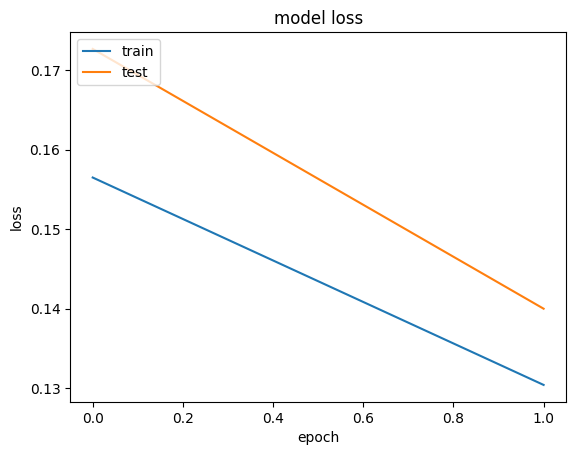

In [51]:
plt.plot(history_df['loss'])
plt.plot(history_df['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Evaluation

In [52]:
test_preds = model.predict(test_gen)
test_true = y_test


389/389 [==============================] - 26s 64ms/step


In [53]:
best_thr, best_f1 = find_best_global_threshold(test_true, test_preds, step=0.01, average="samples")

print("Best global threshold:", best_thr)
print("Best multi-label F1 (samples):", best_f1)
test_predictions_bin = (test_preds >= best_thr).astype(int)



Best global threshold: 0.31
Best multi-label F1 (samples): 0.5561400686400687


Wow! that's the highest score so far. let's continue analyzing.

### Confusion Matrix

In [55]:
test_single_label_df = single_label_df[single_label_df["Id"].isin(test_ids)].copy()
print(f"Single-label images in validation set: {len(test_single_label_df)}")

Single-label images in validation set: 1559


In [56]:
test_single_ids = test_single_label_df["Id"].values
test_single_labels = np.zeros((len(test_single_label_df), NUM_CLASSES), dtype=np.float32)

for i, row in test_single_label_df.iterrows():
    for lbl in row["Target_list"]:
        test_single_labels[np.where(test_single_ids == row["Id"])[0], lbl] = 1.0


test_single_gen = MultiLabelDataGenerator(
    ids=test_single_ids,
    labels=test_single_labels,
    img_dir=TRAIN_PATH,
    batch_size=BATCH_SIZE,
    size=(256,256),
    channels_to_drop=[3],
    shuffle=False
)


In [57]:
single_label_preds = model.predict(test_single_gen)

195/195 [==============================] - 12s 63ms/step


In [58]:

predicted_indices = np.argmax(single_label_preds, axis=1)
true_indices = np.argmax(test_single_labels, axis=1)

cm = confusion_matrix(true_indices, predicted_indices, labels = np.arange(NUM_CLASSES))
f1_sl = f1_score(true_indices, predicted_indices, average='macro', zero_division=0)

print("Single-label F1:", f1_sl)



Single-label F1: 0.3742631096008622


Until now that's the best F1 score for single label, not bad.

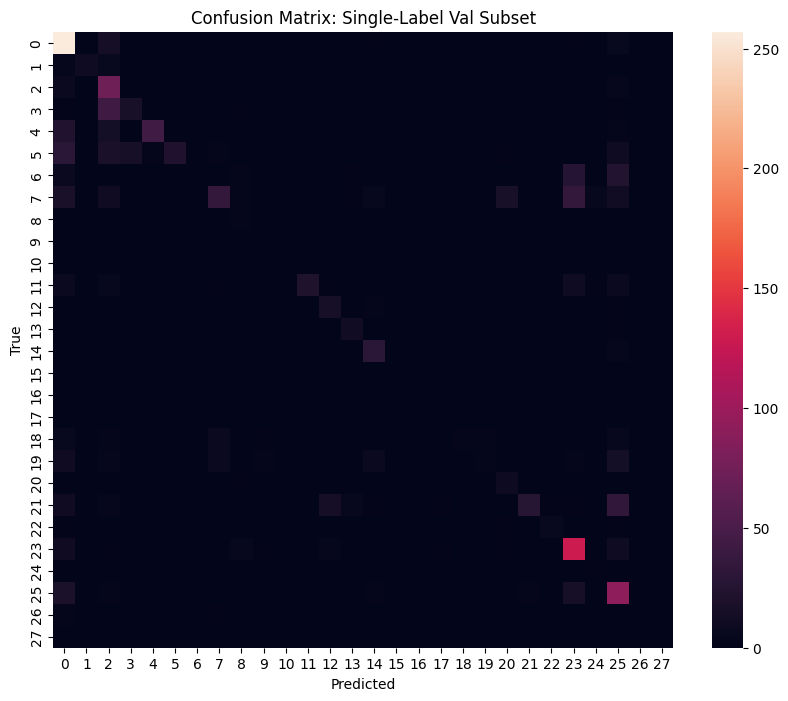

In [59]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt='d')
plt.title("Confusion Matrix: Single-Label Val Subset")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Not bad! We can still see a bias toward common classes, but the overall diagonal pattern has become stronger.

# Changing to Focal loss

To further enhance our ability to detect rare classes, maybe what we should do is change our loss function.
Focal loss is a loss function that was proposed in a 2017 paper (link - https://arxiv.org/pdf/1708.02002), specifically for datasets with class imbalance.

The overall idea is that well classified examples contribute less to the loss function, making the hard to classify examples more important. Thus, this function seems suitable for our problem.

More formally, Focal Loss modifies the CE loss by adding a factor that scales down the loss for well classified examples:

$$
FL(p_t) = -\alpha (1 - p_t)^\gamma \log(p_t)
$$

Where:
- $ p_t $ is the predicted probability for the true class.
- $ (1 - p_t) $ is a measure of how difficult the prediction was - closer to 0 for easy examples, closer to 1 for hard examples.

Thus, when $ p_t $ is large (the example is easy) the loss is lower, making the example influence less the training process. 

There are two additional parameters:

- $ \gamma $ is a "focusing parameter" - it controls how much the loss focuses on hard examples. Higher $ \gamma $ places more emphasis on difficult examples. Common default: $ \gamma = 2 $.
- $ \alpha $ is a "balancing factor" - it balances the importance of positive and negative classes. Common default: $ \alpha = 0.25 $.

the minus arises because $ 0 < p_t < 1 $ so $ \log(p_t) < 0 $.

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers

def build_resnet50_model(input_shape=(224,224,3), num_classes=28):
    base_model = ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='sigmoid', dtype='float32')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)

    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=opt,
        loss='binary_focal_crossentropy',
        metrics=["accuracy"]
    )
    return model
model = build_resnet50_model(input_shape=(224, 224, 3), num_classes=NUM_CLASSES)
model.summary()

This is the same model from before but with a focal loss function.

In [27]:
train_val_ids, test_ids, y_train_val, y_test = train_test_split(
    train_df["Id"].values,
    one_hot_matrix,
    test_size=0.1,
    random_state=42,
    stratify=None
)

train_ids, val_ids, y_train, y_val = train_test_split(
    train_val_ids,
    y_train_val,
    test_size=0.2,
    random_state=42,
    stratify=None
)

print(f"Train size: {len(train_ids)}")
print(f"Val size:   {len(val_ids)}")
print(f"Test size:  {len(test_ids)}")

Train size: 22371
Val size:   5593
Test size:  3108


In [28]:
train_df_split = train_df.set_index("Id").loc[train_ids].reset_index()
val_df_split   = train_df.set_index("Id").loc[val_ids].reset_index()
test_df_split  = train_df.set_index("Id").loc[test_ids].reset_index()

rare_threshold = 700
ultra_rare_threshold = 200

train_df_oversampled = oversample_rare_classes(train_df_split, rare_threshold, ultra_rare_threshold, ultra_rare_over_sampling=True , multiplier=3)
print("New shape after oversampling:", train_df_oversampled.shape)


rare:['Rods & rings', 'Microtubule ends', 'Lysosomes', 'Endosomes', 'Peroxisomes', 'Lipid droplets', 'Mitotic spindle', 'Aggresome', 'Cytoplasmic bodies', 'Cytokinetic bridge', 'Focal adhesion sites', 'Actin filaments']
ultra rare:['Rods & rings', 'Microtubule ends', 'Lysosomes', 'Endosomes', 'Peroxisomes', 'Lipid droplets']
New shape after oversampling: (27781, 32)


In [29]:
def get_label_array(df):

    label_cols = [INDEX_TO_LABEL[i] for i in range(NUM_CLASSES)]
    return df[label_cols].values.astype(np.float32)


train_labels = get_label_array(train_df_oversampled)

val_labels = get_label_array(val_df_split)

test_labels = get_label_array(test_df_split)

train_ids_oversampled = train_df_oversampled["Id"].values
val_ids_split = val_df_split["Id"].values
test_ids_split = test_df_split["Id"].values

BATCH_SIZE = 8

train_gen = MultiLabelDataGenerator(
    ids=train_ids_oversampled,
    labels=train_labels,
    img_dir=TRAIN_PATH,
    batch_size=BATCH_SIZE,
    size=SIZE_224,
    channels_to_drop=[3],
    shuffle=True,
    augment=True
)

val_gen = MultiLabelDataGenerator(
    ids=val_ids_split,
    labels=val_labels,
    img_dir=TRAIN_PATH,
    batch_size=BATCH_SIZE,
    size=SIZE_224,
    channels_to_drop=[3],
    shuffle=False,
    augment=False
)

test_gen = MultiLabelDataGenerator(
    ids=test_ids_split,
    labels=test_labels,
    img_dir=TRAIN_PATH,
    batch_size=BATCH_SIZE,
    size=SIZE_224,
    channels_to_drop=[3],
    shuffle=False,
    augment=False
)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_checkpoint_cb = ModelCheckpoint(
    filepath="resnet_oversample_focal2_checkpoint_epoch_{epoch:02d}_val_loss_{val_loss:.4f}.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=0, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2, verbose=1, restore_best_weights=True
    ),
    model_checkpoint_cb
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=2,
    callbacks=callbacks
)

history_df = pd.DataFrame(history.history)
history_df.to_csv("training_history_resnet50_oversample_focal2.csv", index=False)

### Training progress

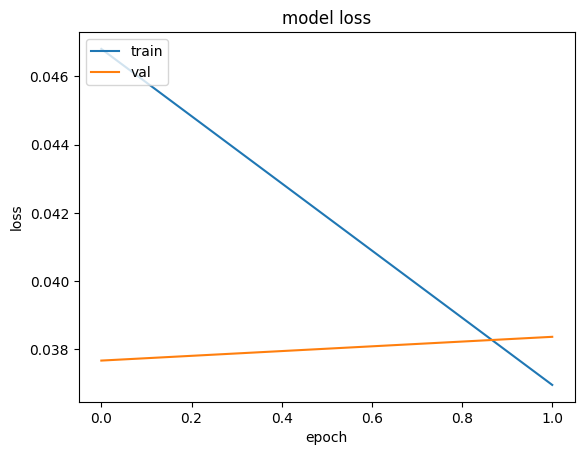

In [32]:
plt.plot(history_df['loss'])
plt.plot(history_df['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [38]:
test_preds = model.predict(test_gen)
test_true = y_test

best_thr, best_f1 = find_best_global_threshold(test_true, test_preds, step=0.01, average="samples")


389/389 [==============================] - 25s 64ms/step


In [39]:
print("Best global threshold:", best_thr)
print("Best multi-label F1 (samples):", best_f1)
test_predictions_bin = (test_preds >= best_thr).astype(int)

Best global threshold: 0.41000000000000003
Best multi-label F1 (samples): 0.5142290249433107


Seems not bad, although we recieved much higher score with the BCE (over 0.04 difference).

let's see the impact on the confusion table.

In [35]:
test_single_label_df = single_label_df[single_label_df["Id"].isin(test_ids)].copy()
print(f"Single-label images in validation set: {len(test_single_label_df)}")
test_single_ids = test_single_label_df["Id"].values
test_single_labels = np.zeros((len(test_single_label_df), NUM_CLASSES), dtype=np.float32)

for i, row in test_single_label_df.iterrows():
    for lbl in row["Target_list"]:
        test_single_labels[np.where(test_single_ids == row["Id"])[0], lbl] = 1.0

test_single_gen = MultiLabelDataGenerator(
    ids=test_single_ids,
    labels=test_single_labels,
    img_dir=TRAIN_PATH,
    batch_size=BATCH_SIZE,
    size=(256, 256),
    channels_to_drop=[3],
    shuffle=False
)

single_label_preds = model.predict(test_single_gen)


Single-label images in validation set: 1559
195/195 [==============================] - 12s 60ms/step


In [36]:
predicted_indices = np.argmax(single_label_preds, axis=1)
true_indices = np.argmax(test_single_labels, axis=1)

cm = confusion_matrix(true_indices, predicted_indices, labels=np.arange(NUM_CLASSES))
f1_sl = f1_score(true_indices, predicted_indices, average='macro', zero_division=0)

print("Single-label F1:", f1_sl)



Single-label F1: 0.29484245513899165


Interesting, although the overall F1 score was relatively high, the same score for single labels performed quite poorly.
Probably suggesting that the algorithm performed better on multi label images.

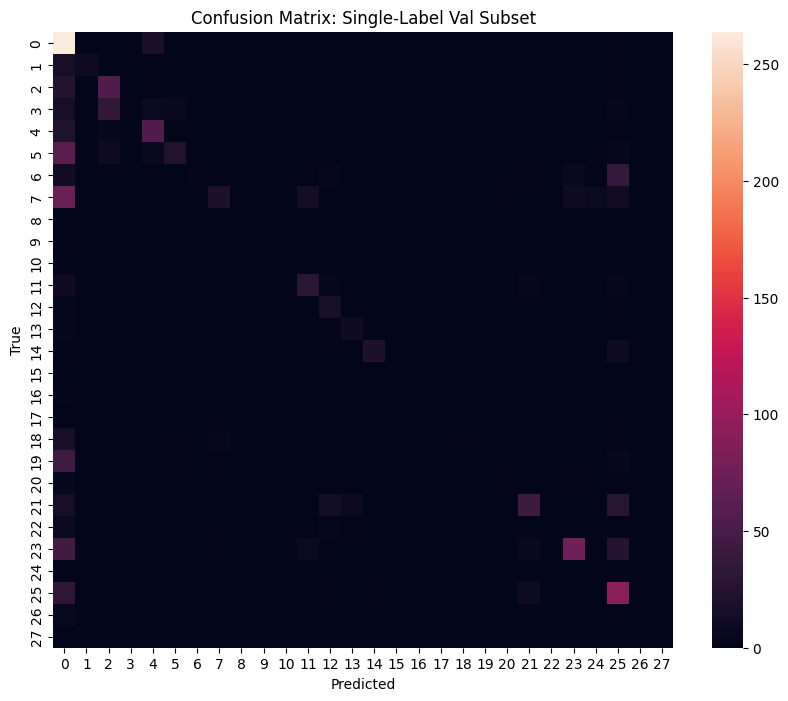

In [37]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt='d')
plt.title("Confusion Matrix: Single-Label Val Subset")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Hmm, still relatively strong diagonal pattern but without much improvement.

# Conclusions

We started with a simple baseline model - a CNN, which performed quite well, especially after fine tuning the thresholds.

Next, we explored whether the red and yellow channels could be ignored. We found that ignoring the red channel, in particular, affected the prediction outcomes.

We then addressed the main challenges of this dataset: its relatively small size and the class imbalance. To tackle the limited data we implemented transfer learning and data augmentations. To address class imbalance we added rare class oversampling and replaced the original BCE loss with focal loss.

Most of these steps brought us closer to our goal. The best performing model was a ResNet50 with oversampling and BCE, achieving an F1 score of 0.55.

Here are several potential directions for future research:

1. Developing an algorithm to tune the thresholds globally, possibly using a gradient descent approach (again this can be tricky because of the fact that the F1 function is not differentiable).
    
2. Incorporating external HPA data. Although we faced challenges in acquiring it, using this data could significantly enhance the results.

3. Experimenting more with focal loss, which is theoretically more suited to this problem.

Working on this challenge was both fun and taught us a lot. Thanks for the opportunity!